## Callin Switzer
March 2018
## DEBUGGING

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import math
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
from matplotlib.patches import Ellipse
from collections import OrderedDict
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import sys
import pandas as pd
import importlib
print(sys.version)
now = datetime.now()
print("last run on " + str(now))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
last run on 2019-03-28 15:51:42.058415


In [7]:
import importlib

In [9]:
import multiProcTraj
import multiProcTraj as mpt

In [10]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    '''
    rho: radius
    phi: angle (in radians)
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

In [11]:
# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData'

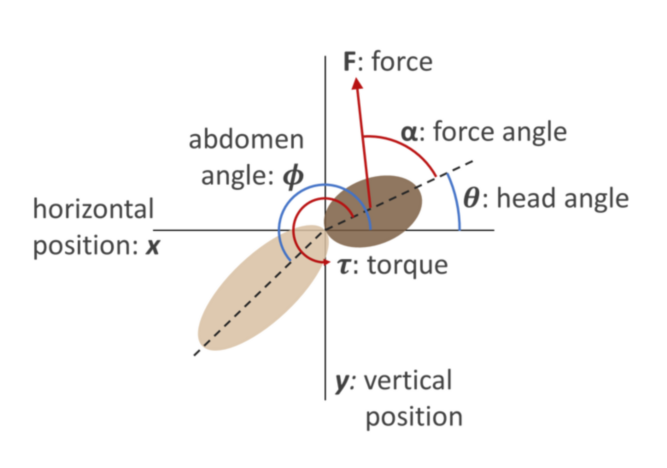

In [12]:
# show moth image
mothFile = os.path.join(os.path.dirname(os.getcwd()), "MothDiagram.PNG")
if os.path.isfile(mothFile):
    img=mpimg.imread(os.path.join(os.path.dirname(os.getcwd()), "MothDiagram.PNG"))
    plt.figure(figsize = [4,4],dpi = 200)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.imshow(img, interpolation='bicubic')

In [13]:
importlib.reload(multiProcTraj)

<module 'multiProcTraj' from 'C:\\Users\\calli\\Documents\\GitRepos\\ODE_Python\\PythonCode\\multiProcTraj.py'>

In [15]:
# run one simulation to compare with Tom's version
pi = np.pi

mpt.bhead = 0.507
mpt.ahead = 0.908
mpt.bbutt  = 0.1295
mpt.abutt  = 1.7475
mpt.rho = 1  #cgs  density of insect 
mpt.rhoA = 0.00118  #cgs density of air
mpt.muA = 0.000186 #cgs viscosity
mpt.L1 = 0.908     #Length from the thorax-abdomen joint to the center of the 
    #head-thorax mass in cm
mpt.L2 = 1.7475   #Length from the thorax-abdomen joint to the center of the 
    #abdomen mass in cm
mpt.L3 = 0.75   #Length from the thorax-abdomen joint to the aerodynamic force 
    #vector in cm
mpt.m1 = mpt.rho*(4/3)*pi*(mpt.bhead**2)*mpt.ahead; #m1 is the mass of the head-thorax
mpt.m2 = mpt.rho*(4/3)*pi*(mpt.bbutt**2)*mpt.abutt; #m2 is the mass of the abdomen 
    #(petiole + gaster)
mpt.echead = mpt.ahead/mpt.bhead; #Eccentricity of head-thorax (unitless)
mpt.ecbutt = mpt.abutt/mpt.bbutt; #Eccentricity of gaster (unitless)
mpt.I1 = (1/5)*mpt.m1*(mpt.bhead**2)*(1 + mpt.echead**2); #Moment of inertia of the 
    #head-thorax
mpt.I2 = (1/5)*mpt.m2*(mpt.bbutt**2)*(1 + mpt.ecbutt**2); #Moment of inertia of the gaster

mpt.S_head = pi*mpt.bhead**2; #This is the surface area of the object experiencing drag.
                #In this case, it is modeled as a sphere.
mpt.S_butt = pi*mpt.bbutt**2; #This is the surface area of the object experiencing drag.
                #In this case, it is modeled as a sphere.

mpt.K = 29.3  #K is the torsional spring constant of the thorax-petiole joint
#     #in (cm^2)*g/(rad*(s^2))
#mpt.K = 1000.0
mpt.c =  14075.8   #c is the torsional damping constant of the thorax-petiole joint
#     #in (cm^2)*g/s

# mpt.c = 1000.0

# refref: set to 980.0    
mpt.g =  0.0   #g is the acceleration due to gravity in cm/(s^2)
mpt.betaR =  0.0 #This is the resting configuration of our 
    #torsional spring(s) = Initial abdomen angle - initial head angle - pi

In [16]:
############# manually enter values #################

x,xd,y,yd = 0, 0.0001, 0, 0.0001
theta,thetad,phi,phid = np.pi/4,0.0001, np.pi/4 + np.pi, 0.0001
F, alpha, tau0 = 40462.5, 5.75, 69825.
# F, alpha, tau0 = 0, 0, 100.

#####################################################

ranges = np.array([[x, x], [xd, xd], [y, y], [yd, yd],   
                   [theta, theta], [thetad, thetad], [phi,phi], [phid, phid]])


tic = time.time()
simLength = 3.0 # seconds
samplesPerSec= 1000
mpt.nstep = int(simLength * samplesPerSec) # steps per second
mpt.t = np.linspace(0, simLength, num = mpt.nstep, endpoint = False) 

nrun = 1 #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nrun, len(mpt.t)])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]
print(x.shape)

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]), )


# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(mpt.FlyTheBug, state0[i, :], mpt.t, args = (F, alpha, tau0))
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
    print(i)
print('elapsed time = ',time.time()-tic)

(1, 3000)
0
elapsed time =  10.475781440734863


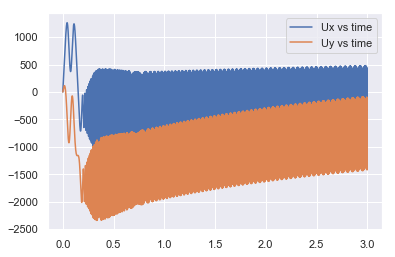

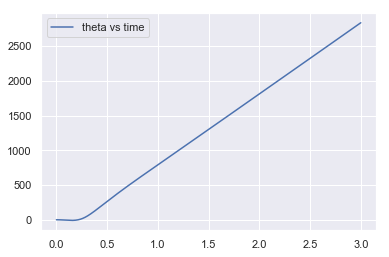

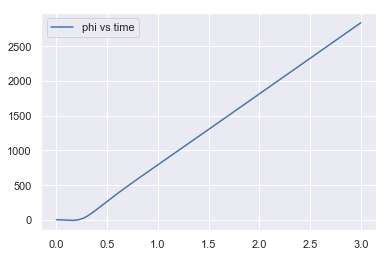

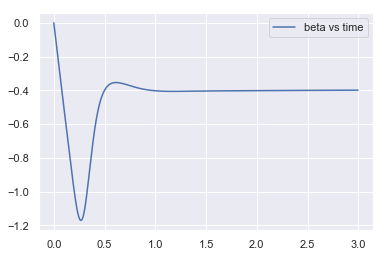

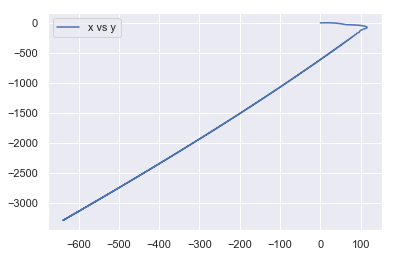

In [17]:
t = mpt.t
pi = np.pi
x = np.array(state[:,[0]])
xd = np.array(state[:,[1]])
y = np.array(state[:,[2]])
yd = np.array(state[:,[3]])
theta = np.array(state[:,[4]])
thetad = np.array(state[:,[5]])
phi = np.array(state[:,[6]])
phid = np.array(state[:,[7]])
#  And let's just plot it all
sns.set()
plt.figure()
plt.plot(t,xd, label = 'Ux vs time')
plt.plot(t,yd, label = 'Uy vs time')
plt.legend()
plt.figure()
plt.plot(t,theta, label = 'theta vs time')
plt.legend()
plt.figure()
plt.plot(t,phi, label = 'phi vs time')
plt.legend()
plt.figure()
plt.plot(t, phi - theta - pi, label = 'beta vs time')
plt.legend()
plt.figure()
plt.plot(x,y, label = 'x vs y')
plt.legend()


In [18]:
beta = phi - theta - pi

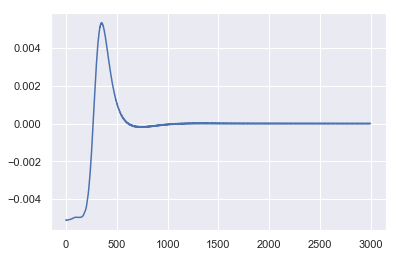

In [19]:
plt.plot(np.diff(beta.reshape(-1)))

In [ ]:
## REFREF: here



# specify ranges
# x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0

np.random.seed(seed=123)

ranges = np.array([[0, 0], [-1500, 1500], [0, 0], [-1500, 1500],   
                   [0, 2*np.pi], [-25, 25], [0, 2*np.pi], [-25, 25], 
                  [0, 44300], [0, 2*np.pi], [-100000, 100000]])



tic = time.time()
mpt.nstep = 100
mpt.t = np.linspace(0, 0.02, num = mpt.nstep, endpoint = True) # time cut into 100 timesteps
mpt.nrun = 100  #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([mpt.nrun, mpt.nstep])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(mpt.nrun, ranges.shape[0]))

# loop through all the runs
for i in range(0,mpt.nrun):
    # run ODE
    F = state0[i,8]
    alpha = state0[i, 9]
    tau0 = state0[i, 10]
    
    state = odeint(mpt.FlyTheBug, state0[i, 0:8], mpt.t,  args = (F, alpha, tau0))
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
print('elapsed time = ',time.time()-tic)

In [ ]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')
for i in range(0,mpt.nrun):
    plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')
    
    
plt.scatter(x[:,-1:][:,0], y[:,-1:][:,0])

In [ ]:
dfa = pd.DataFrame(state0, columns=["x","xd","y","yd","theta","thetad","phi","phid", "F", "alpha", "tau0"])

In [ ]:
df_final = pd.DataFrame(OrderedDict({"xf" : x[:,-1:][:,0], 
              "xdf" : xd[:,-1:][:,0], 
              "yf": y[:,-1:][:,0],
              "ydf" : yd[:,-1:][:,0], 
              "thetaf" : theta[:,-1:][:,0],
              "thetadf" : thetad[:,-1:][:,0], 
              "phif" : phi[:,-1:][:,0], 
              "phidf" : phid[:,-1:][:,0], 
             } ))
df_final.head()

In [ ]:
df_c = pd.concat([dfa.reset_index(drop=True), df_final], axis=1)
df_c.head()

In [ ]:
dataOutput

In [ ]:
#df_c.to_csv(os.path.join(dataOutput, "UpdatedCodeCheck.csv"), index= False)

In [ ]:
# read in Jorge's comparison
checkData = pd.read_csv(os.path.join(dataOutput, "UpdatedCodeCheck_output_all.csv"))

In [ ]:
checkData.columns

In [ ]:
# checkData.columns[0:19] = df_c.loc[:, "x":"phidf"].columns
checkData.rename({'x_0':'x', 'xd_0':'xd', 'y_0':'y', 'yd_0':'yd', 
                 "theta_0":"theta", "thetad_0": "thetad", "phi_0": "phi", "phid_0":"phid" }, axis='columns', inplace = True)
checkData.head()

In [ ]:
# replace data
checkData.loc[:, "x":"phidf"] = df_c.loc[:, "x":"phidf"]

In [ ]:
checkData.head()

In [ ]:
# calculate beta
checkData["beta_0"] = checkData.phi - checkData.theta - np.pi
checkData["betaf"] = checkData.phif - checkData.thetaf - np.pi
checkData["beta_a"] = checkData.phi_a - checkData.theta_a - np.pi

In [ ]:
checkData.head()

In [ ]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')

for i in range(0,mpt.nrun):
    plt.plot(x[i, :],y[i, :], alpha = 0.2)
    
plt.scatter(x[:, -1:], y[:, -1:], c= 'orange', label = "Python")
plt.scatter(checkData.x_a, checkData.y_a, label = "Matlab")
plt.legend()
plt.savefig(os.path.join(figDir, "PythonVsMatlab.png") )
plt.show()

In [ ]:
# plot final positions
def plotMoth(x,y,theta, phi, F, alpha, fig, ax):
    # plot moth and force

    thoraxLen = 0.908 * 2# cm
    abLen = 1.747 *2 #cm
    bodyWidth = 1.1


    # plot trajectory
    #fig, ax = plt.subplots( figsize = [10,10])
    ax.set_aspect('equal', 'datalim')
    #ax.plot(x,y, label = 'trajectory x vs y')

    center = np.array([x, y])
    head = center + np.array(pol2cart(thoraxLen, theta))
    abTip = center + np.array(pol2cart(abLen, phi))



    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi))

    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)

    # plot force 
    forceAlpha = alpha
    forceCenter = midpoint(center, head)
    forceMagnitude = F / 15000 # scale 
    forceAngle = theta + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

In [ ]:
# plt.figure(figsize = [10,10])
# plt.axes().set_aspect('equal', 'datalim')

for i in range(0,3):
    fig, ax = plt.subplots( figsize = [10,10])
    plt.plot(x[i, :],y[i, :], alpha = 0.2)
    # plot final positions
    
    plt.scatter(x[i, -1:], y[i, -1:], c= 'orange', label = "Python")
    plt.scatter(checkData.x_a[i], checkData.y_a[i], label = "Matlab")
    plotMoth(x[i, -1:][0],y[i, -1:][0],theta[i, -1:][0], phi[i, -1:][0], checkData.F[i], checkData.alpha[i], fig, ax)
    plotMoth(checkData.x_a[i],checkData.y_a[i],checkData.theta_a[i], checkData.phi_a[i], checkData.F[i], checkData.alpha[i], fig, ax)
    plt.legend()
    plt.show()

In [ ]:
x.shape # nrun, nstep

In [ ]:
# plotnum of timesteps vs. xf (don't get too high or too low)
# check parameters
# check duration


In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(x[:, -1:].reshape(-1) - checkData.x_a, y[:, -1:].reshape(-1) - checkData.y_a, s = 15, alpha = 0.4, c= "black")
plt.title("Error from matlab vs. python")
plt.savefig(os.path.join(figDir, "PythonVsMatlab_error.png") )
plt.show()

In [ ]:
# visualize error
checkData.columns

In [ ]:
checkData["xf_error"] = checkData.xf - checkData.x_a
checkData["yf_error"] = checkData.yf - checkData.y_a
checkData["thetaf_error"] = checkData.thetaf - checkData.theta_a
checkData["phif_error"] = checkData.phif - checkData.phi_a
checkData["xdf_error"] = checkData.xdf - checkData.xd_a
checkData["ydf_error"] = checkData.ydf - checkData.yd_a
checkData["thetadf_error"] = checkData.thetadf - checkData.thetad_a
checkData["phidf_error"] = checkData.phidf - checkData.phid_a
checkData["betaf_error"] = checkData.betaf - checkData.beta_a

In [ ]:
sns.pairplot(checkData.loc[: , ["yf", "y_a", "yf_error","F", "alpha", "tau0"]])

In [ ]:
checkData["theta_change_py"] = checkData.thetaf - checkData.theta_0
checkData["phi_change_py"] = checkData.phif - checkData.phi_0
checkData["beta_change_py"] = checkData.betaf - checkData.beta_0
checkData["theta_change_mat"] = checkData.theta_a - checkData.theta_0
checkData["phi_change_mat"] = checkData.phi_a - checkData.phi_0
checkData["beta_change_mat"] = checkData.beta_a - checkData.beta_0

x
# checkData["xdf_error"] = checkData.xdf - checkData.xd_a
# checkData["ydf_error"] = checkData.ydf - checkData.yd_a
# checkData["thetadf_error"] = checkData.thetadf - checkData.thetad_a
# checkData["phidf_error"] = checkData.phidf - checkData.phid_a
# checkData["betaf_error"] = checkData.betaf - checkData.beta_a

In [ ]:
sns.pairplot(checkData.loc[: , ["theta_change_py", "phi_change_py", "theta_change_mat", "phi_change_mat", "beta_change_py", "beta_change_mat"]])

In [ ]:
# refref: beta error is highest when beta starts off as negative (greater than -pi radians)
sns.pairplot(checkData.loc[: , ["beta_0", "betaf", "beta_a", "betaf_error","F", "alpha", "tau0"]])

In [ ]:
sns.pairplot(checkData.loc[: , ["beta_0", "thetaf", "thetaf_error", "betaf_error","F", "alpha", "tau0"]])

In [ ]:
# pairplot of errors
# refref: theta and phi errors are super related!
errorCols = checkData.loc[: ,"xf_error":"betaf_error" ].columns

sns.pairplot(checkData.loc[: ,np.hstack([errorCols, "F", "alpha", "tau0"])])

## Visualize moth at different timesteps
* See if moth is spinning
* See if abdomen is rotating too far

In [ ]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')
i =54
plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

In [ ]:
nstep = mpt.nstep

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')
i += 1
ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


# add body positions:
for timestep in (np.linspace(0, nstep - 1, num = 8 )).astype(int):
    center = np.array([x[i, timestep], y[i, timestep]])
    head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
    abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))
    
    
    
    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)
    
    # plot force 
    forceAlpha = state0[i, 9]
    forceCenter = midpoint(center, head)
    forceMagnitude = state0[i, 8] / 15000 # scale 
    #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
    forceAngle = theta[i, timestep] + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

In [ ]:
nrun = mpt.nrun

In [ ]:
# plot moth with ellipses
# refref: what force would it take for the moth to counter-act gravity?
nstep = mpt.nstep
timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.7475 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')

for i in np.random.randint(0, high = nrun, size = 3):
    # plot trajectory
    ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

    # add body positions:
    for timestep in (np.linspace(0, nstep -1, num = 8 )).astype(int):
        center = np.array([x[i, timestep], y[i, timestep]])
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))



        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        ax.add_artist(el)
        ax.add_artist(el2)

        ax.plot(xx, yy, 'k', alpha = 0.2)
        #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
        ax.plot(xab,yab, 'k', alpha = 0.2)
        #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)

        # plot force 
        forceAlpha = state0[i, 9]
        forceCenter = midpoint(center, head)
        forceMagnitude = state0[i, 8] / 15000 # scale 
        #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
        forceAngle = theta[i, timestep] + forceAlpha
        forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
        #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
        ax.arrow(x = forceCenter[0], y = forceCenter[1], 
                 dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
                head_width = 0.2, color = "#B61212")
        
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# scalebar = AnchoredSizeBar(ax.transData,
#                            980/1500, 'Force of gravity', 'lower right', 
#                            pad=0.1,
#                            color="#B61212",
#                            frameon=False,
#                            size_vertical=0.07, sep = 8)

# plt.gca().add_artist(scalebar)
# ax.add_artist(scalebar)

## Calculate Angle from torque

In [ ]:
# reset k to original
# 7 sec, tao = 100, g = 0
# drop back to linear -- see what happens with fixed toque
# do again with damping (set c to 0) set to 0 (should see resonance) -- we should know the resonance for a linear spring
# do c = 0 with no torque (can set nstep = 1000 / sec)
# plot beta (angle b/w thorax and abdomen) vs. time
# plot derivative of beta


# redo with nonlinear spring
# set body angle to 90 degrees, and see what happens. 
# redo with c == 0 
# set drag to 0 c_d = 0

In [ ]:
# reload multiProcTrag
importlib.reload(multiProcTraj)
#print(mpt.g, mpt.K, mpt.springExponent)

# mpt.c = 0.1
#mpt.g = 0.0
# mpt.K = 29.3*100

print(mpt.g, mpt.K, mpt.springExponent)

In [ ]:
np.random.seed(seed=12035)
#  x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0
# ranges = np.array([[0, 0], [0.0001, 0.0001], [0, 0], [0.0001, 0.0001],   
#                    [np.pi/2, np.pi/2], [0, 0], [3*np.pi/2, 3*np.pi/2], [0, 0], 
#                   [0, 0], [0, 0], [0, -100000]])

############# manually enter values #################

x,xd,y,yd = 0, 0.0001, 0, 0.0001
theta,thetad,phi,phid = np.pi/2, 0, np.pi + np.pi/2, 0
F, alpha, tau0 = 0, 0, 4000


#####################################################

ranges = np.array([[x, x], [xd, xd], [y, y], [yd, yd],   
                   [theta, theta], [thetad, thetad], [phi,phi], [phid, phid], 
                  [F, F], [alpha, alpha], [tau0, tau0]])


tic = time.time()
simLength = 30 # seconds
samplesPerSec= 100
mpt.nstep = int(simLength * samplesPerSec) # steps per second
mpt.t = np.linspace(0, simLength, num = mpt.nstep, endpoint = False) # time cut into 100 timesteps

nrun = 1 #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nrun, len(mpt.t)])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]
print(x.shape)

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]), )


# loop through all the runs
for i in range(0,nrun):
    # run ODE
    F = state0[i,8]
    alpha = state0[i, 9]
    tau0 = state0[i, 10]
    
    state = odeint(mpt.FlyTheBug, state0[i, 0:8], mpt.t,  args = (F, alpha, tau0))
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
    print(i)
print('elapsed time = ',time.time()-tic)

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')
i = 0
ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


# add body positions:
for timestep in (np.linspace(0, mpt.nstep -1 , num = 8 )).astype(int):
    center = np.array([x[i, timestep], y[i, timestep]])
    head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
    abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))
    
    
    
    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)
    
    # plot force 
    forceAlpha = state0[i, 9]
    forceCenter = midpoint(center, head)
    forceMagnitude = state0[i, 8] / 15000 # scale 
    #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
    forceAngle = theta[i, timestep] + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

fig = plt.subplots(figsize = np.array([30,8])/ 1.4)
gs = gridspec.GridSpec(3, 1,height_ratios=[1,1,1])

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax.set_aspect('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)



ctr1 = 0
for i in range(0, nrun):

    # add body positions:
    ctr = 0
    for timestep in (np.linspace(0, mpt.nstep - 1, num = 40)).astype(int):
        #center = np.array([x[i, timestep], y[i, timestep]])
        center = np.array([ctr,ctr1])
        ctr += 3
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))

        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        if np.mod(ctr, 1) == 0:
            ax.add_artist(el)
            ax.add_artist(el2)

            ax.plot(xx, yy, 'k', alpha = 0.2)
            ax.plot(xab,yab, 'k', alpha = 0.2)

    #plt.annotate("tau = " + str(np.round(state0[i,10])), center + (5, 1))
    ax.set_title(r'$\tau$ =' + str(np.round(state0[i,10], 5))+ ", g = " + str(mpt.g) + ", spring Exp. = " + str(mpt.springExponent) + ", c = " + str(mpt.c))
    ax.set_xlabel("")
    ax.set_xticks([0, 120, 126])
    ax.set_xticklabels([0, np.round(np.max(mpt.t)), ""])
    
    ax.set_ylim([-4,3])
    ax.set_yticks([])
  
    ctr1 -= 8
    



ax1.plot(mpt.t, [math.degrees(phi[i, jj] - theta[i, jj] - np.pi) for jj in range(len(phi[i,:]))])
#ax1.hlines(-0, xmin = 0, xmax = np.max(mpt.t))
ax1.set_ylabel("degrees b/w\nthorax and abdomen")
ax1.set_xlabel("")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


degs =  np.array([math.degrees(phi[i, jj] - theta[i, jj]) for jj in range(len(phi[i,:]))])
ax2.plot(mpt.t[2:], np.diff(degs[1:]) * samplesPerSec)
ax2.set_ylabel("change in degrees")
ax2.set_xlabel("Time (s)")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.savefig(os.path.join(mpt.figDir, "TauAndAngle3_noDamping.png"), dpi = 150) 
plt.show()



In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

fig = plt.subplots(figsize = np.array([30,8])/ 1.4)
gs = gridspec.GridSpec(3, 1,height_ratios=[1,1,1])

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax.set_aspect('equal')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)



ctr1 = 0
for i in range(0, nrun):

    # add body positions:
    ctr = 0
    for timestep in (np.linspace(0, mpt.nstep - 1, num = 40)).astype(int):
        #center = np.array([x[i, timestep], y[i, timestep]])
        center = np.array([ctr,ctr1])
        ctr += 3
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))

        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        if np.mod(ctr, 1) == 0:
            ax.add_artist(el)
            ax.add_artist(el2)

            ax.plot(xx, yy, 'k', alpha = 0.2)
            ax.plot(xab,yab, 'k', alpha = 0.2)

    #plt.annotate("tau = " + str(np.round(state0[i,10])), center + (5, 1))
    ax.set_title(r'$\tau$ =' + str(np.round(state0[i,10], 5))+ ", g = " + str(mpt.g) + ", spring Exp. = " + str(mpt.springExponent) + ", c = " + str(mpt.c))
    ax.set_xlabel("")
    ax.set_xticks([0, 120, 126])
    ax.set_xticklabels([0, np.round(np.max(mpt.t)), ""])
    
    ax.set_ylim([-4,3])
    ax.set_yticks([])
  
    ctr1 -= 8
    



ax1.plot(mpt.t, [math.degrees(phi[i, jj]) for jj in range(len(phi[i,:]))])
#ax1.hlines(-0, xmin = 0, xmax = np.max(mpt.t))
ax1.set_ylabel("phi")
ax1.set_xlabel("")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


degs =  np.array([math.degrees(phi[i, jj] - theta[i, jj]) for jj in range(len(phi[i,:]))])
ax2.plot(mpt.t, [math.degrees(theta[i, jj]) for jj in range(len(phi[i,:]))])
ax2.set_ylabel("theta")
ax2.set_xlabel("Time (s)")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plt.show()



In [ ]:

fig, ax = plt.subplots( figsize = [10,3])
plt.plot(mpt.t, [math.degrees(phi[i, jj] - theta[i, jj]) for jj in range(len(phi[i,:]))])
plt.hlines(-180, xmin = 0, xmax = np.max(mpt.t))
plt.show()

In [ ]:
plt.plot(mpt.t)

In [ ]:
nrun

In [ ]:
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(theta[i, jj]) for jj in range(len(phi[i,:]))])
    plt.show()
  

In [ ]:

for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(theta[i, jj]) for jj in range(len(phi[i,:]))])
    plt.show()
  

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


#ax.set_aspect('equal')

ctr1 = 0
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot((phi[i, :] - theta[i, :]) - np.pi)
    plt.ylim(0, 10)
    plt.hlines(y = np.pi, xmin = 0, xmax = 10000)
    plt.show()
  
    

In [ ]:
print("tau = ", state0[i,10])
plt.show()
plt.plot((phi[i, :] - theta[i, :]) - np.pi)

plt.show()

In [ ]:
center

# See if abdomen twangs

In [ ]:
np.random.seed(seed=12035)
#  x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0
# ranges = np.array([[0, 0], [0.0001, 0.0001], [0, 0], [0.0001, 0.0001],   
#                    [np.pi/2, np.pi/2], [0, 0], [3*np.pi/2, 3*np.pi/2], [0, 0], 
#                   [0, 0], [0, 0], [0, -100000]])


ranges = np.array([[0, 0], [0.0001, 0.0001], [0, 0], [0.0001, 0.0001],   
                   [-np.pi/4, -np.pi/4], [0, 0], [3*np.pi/2, 3*np.pi/2], [0, 0], 
                  [0, 0], [0, 0], [0, 0]])


tic = time.time()
nstep = 5000000
t = np.linspace(0, 7, num = nstep, endpoint = False) # time cut into 100 timesteps
nrun = 1 #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nrun, nstep])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]), )

# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(FlyTheBug, state0[i, :], t)
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
    print(i)
print('elapsed time = ',time.time()-tic)

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

fig, ax = plt.subplots( figsize = [30,10])
ax.set_aspect('equal')

ctr1 = 0
for i in range(0, nrun):

    # add body positions:
    ctr = 0
    for timestep in (np.linspace(0, nstep - 1, num = 40)).astype(int):
        #center = np.array([x[i, timestep], y[i, timestep]])
        center = np.array([ctr,ctr1])
        ctr += 3
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))

        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        ax.add_artist(el)
        ax.add_artist(el2)

        ax.plot(xx, yy, 'k', alpha = 0.2)
        ax.plot(xab,yab, 'k', alpha = 0.2)

    #plt.annotate("tau = " + str(np.round(state0[i,10])), center + (5, 1))
    plt.annotate(r'$\tau$ =' + str(np.round(state0[i,10], 5)), center + (5, 1))
    plt.xlabel("Time (sec)")
    plt.xticks([0, 120, 130],  [0, np.round(np.max(t)), ""])
    plt.yticks([-4,3])
  
    ctr1 -= 8
    
fig.savefig(os.path.join(figDir, "ZeroTorqueAngle.png"), dpi = 150) 
plt.show()


In [ ]:
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(phi[i, jj] - theta[i, jj] ) for jj in range(len(phi[i,:]))])
    #plt.hlines(360, xmin = 0, xmax = nstep)
    plt.ylabel("Degrees")
    plt.xlabel("nstep")
    plt.show()